In [1]:
import pandas as pd 
import numpy as np 
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

# Models
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

import math

import datetime
from datetime import datetime as dt
from dateutil.relativedelta import *
from datetime import timedelta


In [2]:
df_axs = pd.read_csv(r'../data/cryptoInd/axs_ind.csv')
close = df_axs['close']
df_axs.drop('close', axis = 1, inplace = True)
df_axs['close'] = close

In [3]:
df_axs.head(10)

,Date,adj_close,low,high,open,volume,SMA30,CMA30,EMA30,adx,...,macd,macdsignal,macdhist,rsi,stdev,slowk,slowd,dollar_close,sp500_close,close
0,2020-12-07,0.563159,0.468437,0.574726,0.478842,12668046.0,0.458440,0.407105,0.462325,41.648341,...,0.048347,0.052141,-0.003793,63.699261,0.051268,68.690839,55.822600,90.789001,3691.959961,0.563159
1,2020-12-08,0.569973,0.527272,0.638384,0.562637,21443069.0,0.462381,0.411758,0.475781,41.841243,...,0.052057,0.052124,-0.000067,64.063314,0.057087,72.878099,62.216147,90.968002,3702.250000,0.569973
2,2020-12-09,0.628394,0.558831,0.674994,0.570928,17429921.0,0.472999,0.417776,0.494858,42.251417,...,0.059031,0.053506,0.005526,67.094717,0.070573,80.562759,74.043899,91.083000,3672.820068,0.628394
3,2020-12-10,0.564398,0.556939,0.636709,0.629043,8065085.0,0.482884,0.421739,0.503550,42.600358,...,0.058717,0.054548,0.004169,61.050475,0.072278,67.235916,73.558925,90.820000,3668.100098,0.564398
4,2020-12-11,0.551329,0.500087,0.577429,0.564369,7991105.0,0.495020,0.425149,0.509523,41.947024,...,0.056759,0.054990,0.001769,59.870379,0.067296,57.945349,68.581341,90.970001,3663.459961,0.551329
5,2020-12-12,0.576097,0.551251,0.621803,0.551480,6963430.0,0.508252,0.429019,0.517844,41.681608,...,0.056555,0.055303,0.001252,61.385983,0.062235,45.301017,56.827428,90.970001,3663.459961,0.576097
6,2020-12-13,0.611444,0.566253,0.617044,0.577264,6632681.0,0.520439,0.433580,0.529544,41.433886,...,0.058569,0.055956,0.002613,63.494164,0.063341,49.084708,50.777025,90.970001,3663.459961,0.611444
7,2020-12-14,0.638922,0.580680,0.665775,0.611878,10156872.0,0.531292,0.438588,0.543217,41.568035,...,0.061672,0.057099,0.004573,65.082008,0.068551,63.638933,52.674886,90.731003,3647.489990,0.638922
8,2020-12-15,0.730603,0.610531,0.742450,0.637942,10788659.0,0.549572,0.445541,0.566640,42.181964,...,0.070714,0.059822,0.010892,69.780799,0.081483,80.857096,64.526912,90.408997,3694.620117,0.730603
9,2020-12-16,0.743592,0.694224,0.798117,0.729345,18889339.0,0.571721,0.452472,0.588759,43.055542,...,0.078029,0.063464,0.014565,70.385721,0.085935,85.606006,76.700678,90.359001,3701.169922,0.743592


In [4]:
fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=df_axs['Date'], y=df_axs['close'], name='BITCOIN', mode='lines',line=dict(color='red')))
fig2.show()

In [5]:
inicial_date = '2021-08-10'
df_axs['Date'] = pd.to_datetime(df_axs['Date'])
inicial_date = pd.to_datetime(inicial_date)
df_axs = df_axs[df_axs['Date'] >= inicial_date]

# Scaling

In [6]:
df_axs.set_index('Date', inplace=True)
scaled_df = df_axs.copy()
scaler = MinMaxScaler()
scaled_feat = scaler.fit_transform(df_axs)
scaled_df = pd.DataFrame(scaled_feat, index = df_axs.index, columns=df_axs.columns)
scaled_df.head()

,adj_close,low,high,open,volume,SMA30,CMA30,EMA30,adx,bb_low,...,macd,macdsignal,macdhist,rsi,stdev,slowk,slowd,dollar_close,sp500_close,close
Date,,,,,,,,,,,,,,,,,,,,,
2021-08-10,0.179519,0.026043,0.163928,0.000000,0.926737,0.000000,0.000000,0.000000,0.742013,0.063329,...,0.644534,0.688687,0.343323,0.952699,0.160901,0.675016,0.574946,0.104972,0.425095,0.179519
2021-08-11,0.198371,0.204176,0.268968,0.174468,1.000000,0.012542,0.005746,0.028569,0.770243,0.034191,...,0.688086,0.702170,0.418883,0.969182,0.240097,0.770528,0.670296,0.090900,0.434139,0.198371
2021-08-12,0.196482,0.203752,0.242585,0.194914,0.707126,0.025765,0.011429,0.053294,0.796399,0.018514,...,0.718221,0.719928,0.453907,0.962552,0.294574,0.848202,0.807681,0.103226,0.463570,0.196482
2021-08-13,0.234633,0.224851,0.242037,0.193033,0.349555,0.042852,0.017503,0.080450,0.820812,0.003983,...,0.751005,0.741721,0.486946,0.996233,0.353919,0.786104,0.848397,0.049199,0.475026,0.234633
2021-08-14,0.211303,0.218540,0.217448,0.230450,0.194226,0.058735,0.023272,0.100835,0.840385,0.002625,...,0.764757,0.762337,0.477309,0.914222,0.385647,0.792585,0.856481,0.049199,0.475026,0.211303


# Correlation Matrix

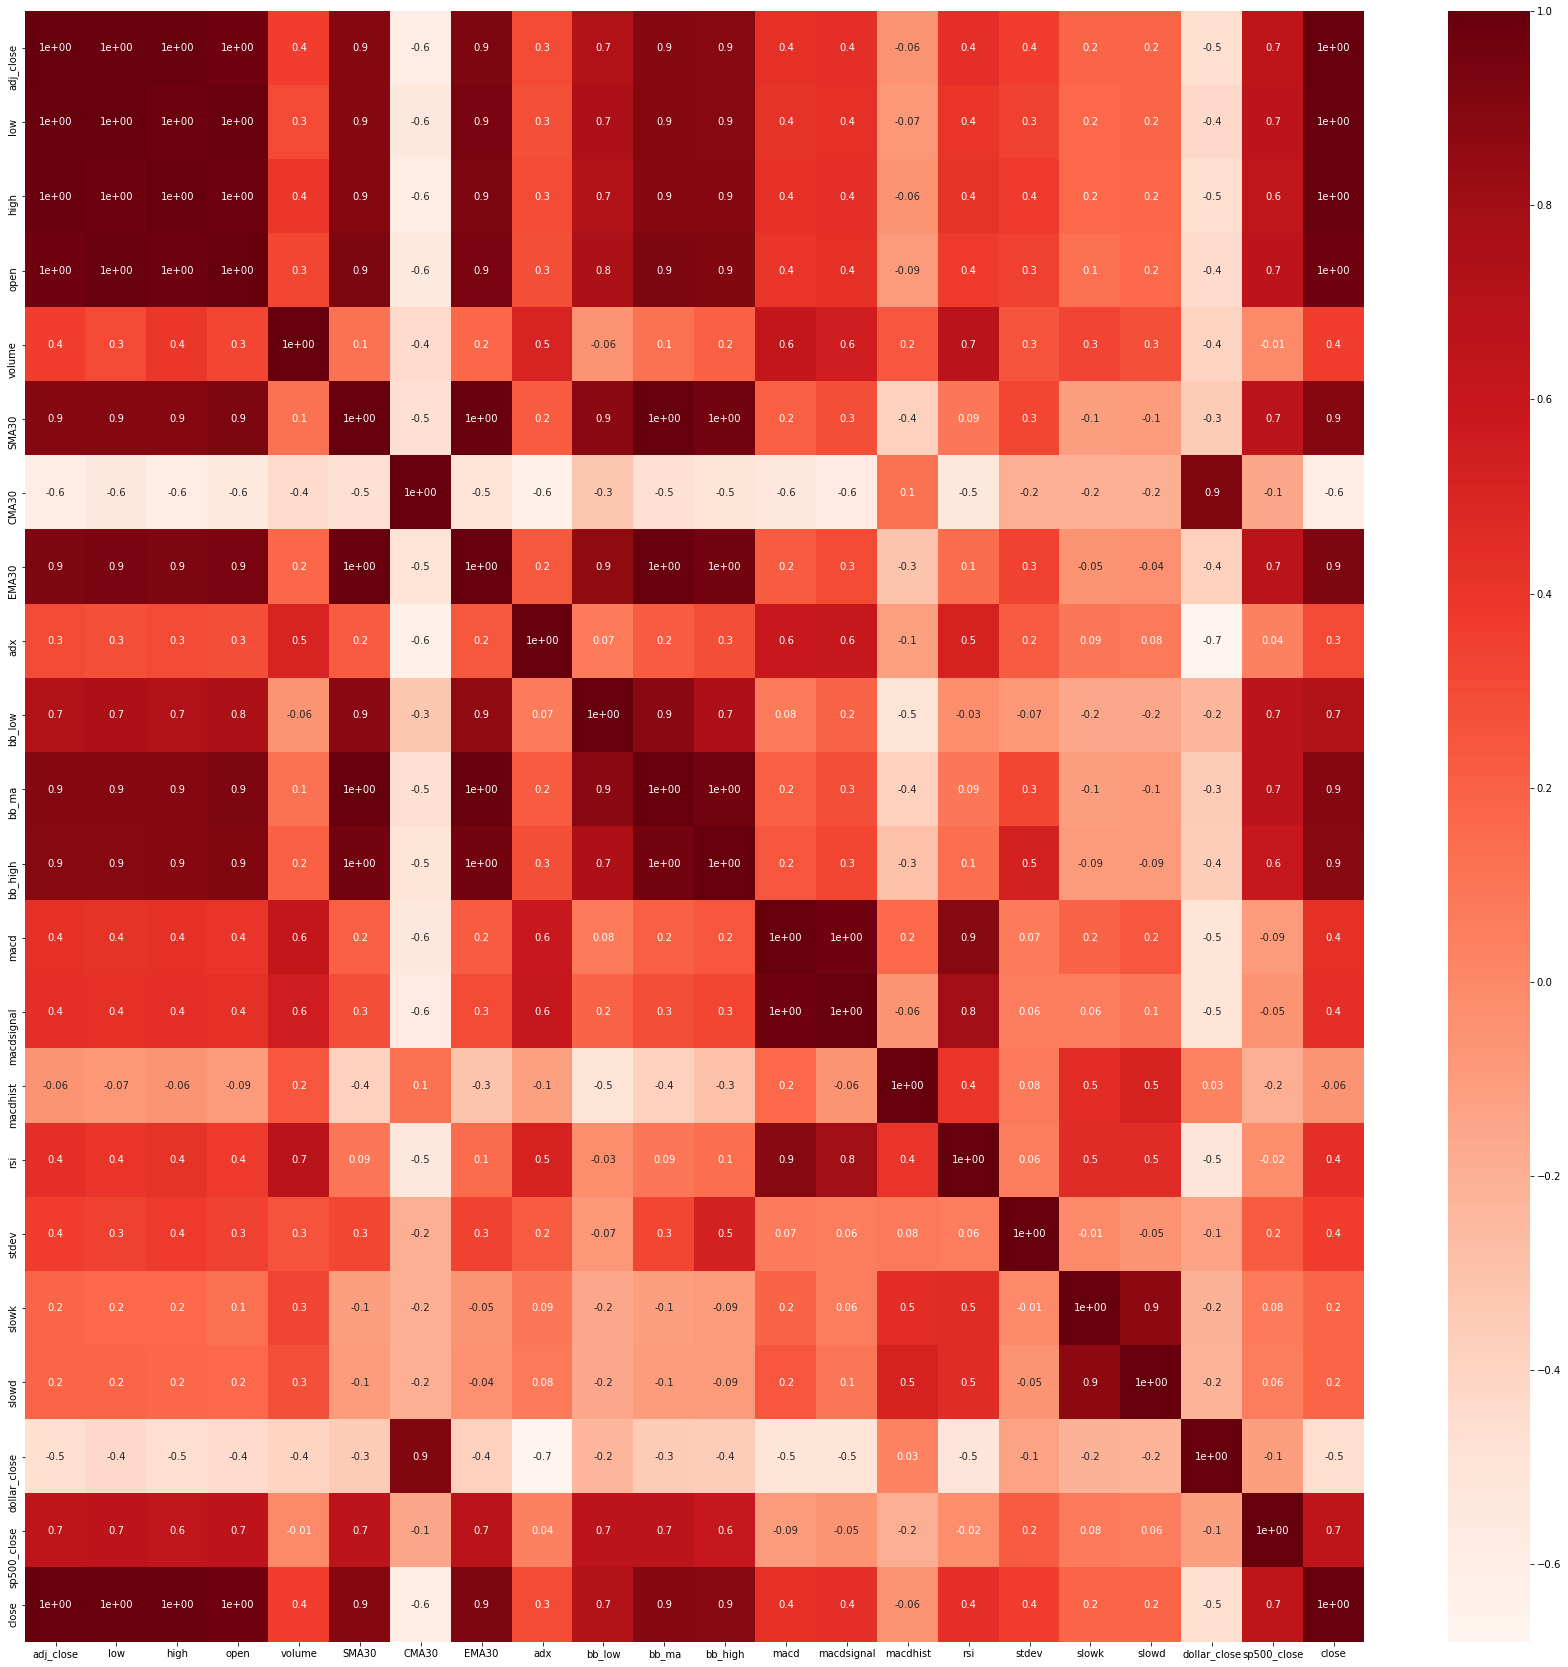

In [7]:
#Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(scaled_df.corr(method="spearman"), decimals=2)

def cor_heatmap(cor):
    plt.figure(figsize=(30,30))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1')
    plt.show()


cor_heatmap(corr)

In [8]:
scaled_df.columns

Index(['adj_close', 'low', 'high', 'open', 'volume', 'SMA30', 'CMA30', 'EMA30',
       'adx', 'bb_low', 'bb_ma', 'bb_high', 'macd', 'macdsignal', 'macdhist',
       'rsi', 'stdev', 'slowk', 'slowd', 'dollar_close', 'sp500_close',
       'close'],
      dtype='object')

In [10]:
scaled_df.drop(['low', 'adj_close', 'open','EMA30','SMA30','macd','macdsignal',
 'bb_ma', 'bb_high'], axis=1, inplace=True)

## TimeBaseCV

In [11]:
import pandas as pd
import datetime
from datetime import datetime as dt
from dateutil.relativedelta import *

# code from: https://towardsdatascience.com/time-based-cross-validation-d259b13d42b8"

class TimeBasedCV(object):
    '''
    Parameters 
    ----------
    train_period: int
        number of time units to include in each train set
        default is 30
    test_period: int
        number of time units to include in each test set
        default is 7
    freq: string
        frequency of input parameters. possible values are: days, months, years, weeks, hours, minutes, seconds
        possible values designed to be used by dateutil.relativedelta class
        deafault is days
    '''
    
    
    def __init__(self, train_period=30, test_period=7, freq='days'):
        self.train_period = train_period
        self.test_period = test_period
        self.freq = freq

        
        
    def split(self, data, validation_split_date=None, date_column='record_date', gap=0):
        '''
        Generate indices to split data into training and test set
        
        Parameters 
        ----------
        data: pandas DataFrame
            your data, contain one column for the record date 
        validation_split_date: datetime.date()
            first date to perform the splitting on.
            if not provided will set to be the minimum date in the data after the first training set
        date_column: string, deafult='record_date'
            date of each record
        gap: int, default=0
            for cases the test set does not come right after the train set,
            *gap* days are left between train and test sets
        
        Returns 
        -------
        train_index ,test_index: 
            list of tuples (train index, test index) similar to sklearn model selection
        '''
        
        # check that date_column exist in the data:
        try:
            data[date_column]
        except:
            raise KeyError(date_column)
                    
        train_indices_list = []
        test_indices_list = []

        if validation_split_date==None:
            validation_split_date = data[date_column].min().date() + eval('relativedelta('+self.freq+'=self.train_period)')
        
        start_train = validation_split_date - eval('relativedelta('+self.freq+'=self.train_period)')
        end_train = start_train + eval('relativedelta('+self.freq+'=self.train_period)')
        start_test = end_train + eval('relativedelta('+self.freq+'=gap)')
        end_test = start_test + eval('relativedelta('+self.freq+'=self.test_period)')

        while end_test < data[date_column].max().date():
            # train indices:
            cur_train_indices = list(data[(data[date_column].dt.date>=start_train) & 
                                     (data[date_column].dt.date<end_train)].index)

            # test indices:
            cur_test_indices = list(data[(data[date_column].dt.date>=start_test) &
                                    (data[date_column].dt.date<end_test)].index)
            
            #print("Train period:",start_train,"-" , end_train, ", Test period", start_test, "-", end_test,
            #      "# train records", len(cur_train_indices), ", # test records", len(cur_test_indices))

            train_indices_list.append(cur_train_indices)
            test_indices_list.append(cur_test_indices)

            # update dates:
            start_train = start_train + eval('relativedelta('+self.freq+'=self.test_period)')
            end_train = start_train + eval('relativedelta('+self.freq+'=self.train_period)')
            start_test = end_train + eval('relativedelta('+self.freq+'=gap)')
            end_test = start_test + eval('relativedelta('+self.freq+'=self.test_period)')

        # mimic sklearn output  
        index_output = [(train,test) for train,test in zip(train_indices_list,test_indices_list)]

        self.n_splits = len(index_output)
        
        return index_output
    
    
    def get_n_splits(self):
        """Returns the number of splitting iterations in the cross-validator
        Returns
        -------
        n_splits : int
            Returns the number of splitting iterations in the cross-validator.
        """
        return self.n_splits

# Models

## Function to Apply the Models

In [12]:
def add_days(df, forecast_length):
    end_point = len(df)
    df1 = pd.DataFrame(index=range(forecast_length), columns=range(2))
    df1.columns = ['close', 'Date']
    df = df.append(df1)
    df = df.reset_index(drop=True)
    x = df.at[end_point - 1, 'Date']
    x = pd.to_datetime(x, format='%Y-%m-%d')
    for i in range(forecast_length):
        df.at[df.index[end_point + i], 'Date'] = x + timedelta(days=1+i)
        df.at[df.index[end_point + i], 'close'] = 0
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
    df = df.drop(['Date'], axis=1)
    return df

In [13]:
def forecasting(model,df1, forecast_length):
    df3 = df1[['close', 'Date']]
    df3 = add_days(df3, forecast_length)
    finaldf = df1.drop('Date', axis=1)
    finaldf = finaldf.reset_index(drop=True)
    end_point = len(finaldf)
    x = end_point - forecast_length
    finaldf_train = finaldf.loc[:x - 1, :]
    finaldf_train_x = finaldf_train.loc[:, finaldf_train.columns != 'close']
    finaldf_train_y = finaldf_train['close']

    fit = model.fit(finaldf_train_x, finaldf_train_y)
    yhat = []
    end_point = len(finaldf)
    df3_end = len(df3)
    for i in range(forecast_length, 0, -1):
        y = end_point - i
        inputfile = finaldf.loc[y:end_point, :]
        inputfile_x = inputfile.loc[:, inputfile.columns != 'close']
        pred_set = inputfile_x.head(1)
        pred = fit.predict(pred_set)
        df3.at[df3.index[df3_end - i], 'close'] = pred[0]
        finaldf = df1.drop('Date', axis=1)
        finaldf = finaldf.reset_index(drop=True)
        yhat.append(pred)
    yhat = np.array(yhat)
    return yhat

In [14]:
def show_results(df_results, df,objetive,train_period_split,test_period_split, *args):
    #Scalling
    scaler = MinMaxScaler()
    scaled_feat = scaler.fit_transform(df)
    scaled_df = pd.DataFrame(scaled_feat, index = df.index, columns=df.columns)

    X_scaled = scaled_df.drop(objetive, axis=1)
    y_scaled = scaled_df[objetive]

    X_tbcv = X_scaled.reset_index()
    y_scaled = y_scaled.reset_index()
    y_scaled['Date'] = pd.to_datetime(y_scaled['Date'], format='%Y-%m-%d')   
    X_tbcv['Date'] = pd.to_datetime(X_tbcv['Date'], format='%Y-%m-%d')                
    tscv = TimeBasedCV(train_period=train_period_split,
        test_period=test_period_split,
        freq='days')
    colours =['red', 'blue', 'yellow', 'pink']
    fig2 = go.Figure()
    count = 0
    for idx,arg in enumerate(args):
        for train_index, test_index in tscv.split(X_tbcv,date_column='Date'):
            X_train = X_tbcv.loc[train_index]
            y_train = y_scaled.loc[train_index]
            X_train['close'] = y_train['close']
            y_test  = y_scaled.loc[test_index]
            X_test = X_tbcv.loc[test_index]
            X_test.set_index('Date', inplace=True)
            y_test.set_index('Date', inplace=True)
            mae_list = []
            mse_list = []
            r2_list = []
            rmse_list = []
            y_pred_test = forecasting(model=arg,df1=X_train,forecast_length=test_period_split)
            # prints metric results         
            value_mae = mean_absolute_error(y_test, y_pred_test)
            value_mse = mean_squared_error(y_test, y_pred_test)
            value_r2 = r2_score(y_test, y_pred_test)
            value_rmse = math.sqrt(value_mse)
            #print(value_mae, value_mse, value_r2)
            # append the accuracies, the time and the number of iterations in the corresponding list
            mae_list.append(value_mae)
            mse_list.append(value_mse)
            r2_list.append(value_r2)
            rmse_list.append(value_rmse)

            real_name = 'real '+ str(X_test.index.min().day)+"-"+ str(X_test.index.min().month)+"-"+ str(X_test.index.min().year)+" to "\
                + str(X_test.index.max().day)+"-"+ str(X_test.index.max().month)+"-"+ str(X_test.index.max().year)
            pred_name = 'pred '+ str(X_test.index.min().day)+"-"+ str(X_test.index.min().month)+"-"+ str(X_test.index.min().year)+" to"\
                + str(X_test.index.max().day)+"-"+ str(X_test.index.max().month)+"-"+ str(X_test.index.max().year)
            X_train['close'] = y_train['close']
            X_pred_test = X_test.copy()
            X_test['close'] = y_test['close']
            X_pred_test['close'] = y_pred_test
            X_pred_test_undo = scaler.inverse_transform(X_pred_test)
            X_test_undo = scaler.inverse_transform(X_test)

            X_pred_test_graphic = pd.DataFrame(data = X_pred_test_undo, index = X_pred_test.index, columns=X_pred_test.columns)
            X_test_graphic = pd.DataFrame(data =X_test_undo, index = X_test.index, columns=X_test.columns)

            fig2.add_trace(go.Scatter(x=X_test_graphic.index, y=X_test_graphic['close'], name=real_name, mode='lines',line=dict(color='green')))
            fig2.add_trace(go.Scatter(x=X_pred_test_graphic.index, y=X_pred_test_graphic['close'], name=pred_name, mode='lines', line=dict(color=colours[idx])))

        fig2.update_layout(dict(updatemenus=[
                                dict(
                                type = "buttons",
                                direction = "left",
                                buttons=list([
                                        dict(
                                        args=["visible", "legendonly"],
                                        label="Deselect All",
                                        method="restyle"
                                        ),
                                        dict(
                                        args=["visible", True],
                                        label="Select All",
                                        method="restyle"
                                        )
                                ]),
                                pad={"r": 10, "t": 10},
                                showactive=False,
                                x=1,
                                xanchor="right",
                                y=1.1,
                                yanchor="top"
                                ),
                        ]
                ))
        mae = round(np.mean(mae_list),10)
        mse = round(np.mean(mse_list),10)
        r2 = round(np.mean(r2_list),10)
        rmse = round(np.mean(rmse_list),10)
        df_results.iloc[count] = mae, mse,rmse, r2
        count+=1
    fig2.show()
    return df_results
        
    

In [15]:
def avg_score(model, X, splits,objetive = 'close',split_method = 'tscv', train_period_split = 30,test_period_split=7):
        #final dataset
        df=pd.DataFrame()

        #Scalling
        scaler = MinMaxScaler()
        scaled_feat = scaler.fit_transform(X)
        scaled_df = pd.DataFrame(scaled_feat, index = X.index, columns=X.columns)

        X_scaled = scaled_df.drop(objetive, axis=1)
        y_scaled = scaled_df[objetive]

        # create lists to store the results from the different models 
        mae_list = []
        mse_list = []
        r2_list = []
        rmse_list =[]
        flag = 0 # feat sel flag to not keep printing 
    
        if split_method == 'hmcv':
                X_tbcv = X_scaled.reset_index()
                y_scaled = y_scaled.reset_index()
                y_scaled['Date'] = pd.to_datetime(y_scaled['Date'], format='%Y-%m-%d')   
                X_tbcv['Date'] = pd.to_datetime(X_tbcv['Date'], format='%Y-%m-%d')                
                tscv = TimeBasedCV(train_period=train_period_split,
                        test_period=test_period_split,
                        freq='days')

                fig = make_subplots(rows=1, cols=1)
                fig2 = go.Figure()

                for train_index, test_index in tscv.split(X_tbcv,date_column='Date'):
                        X_train = X_tbcv.loc[train_index]
                        y_train = y_scaled.loc[train_index]
                        X_test  = X_tbcv.loc[test_index]
                        y_test  = y_scaled.loc[test_index]
                        X_train.set_index('Date', inplace=True) 
                        y_train.set_index('Date', inplace=True)             
                        X_test.set_index('Date', inplace=True)
                        y_test.set_index('Date', inplace=True)


                        # applies the model 
                        model_fit = model.fit(X_train, y_train)
                        #predicts validation 
                        y_pred_test = model_fit.predict(X_test)
                
                        # prints metric results         
                        value_mae = mean_absolute_error(y_test, y_pred_test)
                        value_mse = mean_squared_error(y_test, y_pred_test)
                        value_rmse = math.sqrt(value_mse)
                        value_r2 = r2_score(y_test, y_pred_test)
                        # append the accuracies, the time and the number of iterations in the corresponding list
                        mae_list.append(value_mae)
                        mse_list.append(value_mse)
                        r2_list.append(value_r2)
                        rmse_list.append(value_rmse)
              

                
                        real_name = 'real '+ str(X_test.index.min().day)+"-"+ str(X_test.index.min().month)+"-"+ str(X_test.index.min().year)+" to "\
                                   + str(X_test.index.max().day)+"-"+ str(X_test.index.max().month)+"-"+ str(X_test.index.max().year)
                        pred_name = 'pred '+ str(X_test.index.min().day)+"-"+ str(X_test.index.min().month)+"-"+ str(X_test.index.min().year)+" to"\
                                   + str(X_test.index.max().day)+"-"+ str(X_test.index.max().month)+"-"+ str(X_test.index.max().year)+" "

                        X_train['close'] = y_train
                        X_pred_test = X_test.copy()
                        X_test['close'] = y_test
                        X_pred_test['close'] = y_pred_test

                        X_pred_test_undo = scaler.inverse_transform(X_pred_test)
                        X_test_undo = scaler.inverse_transform(X_test)

                        X_pred_test_graphic = pd.DataFrame(data = X_pred_test_undo, index = X_pred_test.index, columns=X_pred_test.columns)
                        X_test_graphic = pd.DataFrame(data =X_test_undo, index = X_test.index, columns=X_test.columns)

                        fig2.add_trace(go.Scatter(x=X_test_graphic.index, y=X_test_graphic['close'], name=real_name, mode='lines',line=dict(color='green')))
                        fig2.add_trace(go.Scatter(x=X_pred_test_graphic.index, y=X_pred_test_graphic['close'], name=pred_name, mode='lines', line=dict(color='red')))
                        
                        #df.append(y_pred_test)
                
                model_name = str(model)+"Number of Splits: "+ str(tscv.get_n_splits())
        
                fig2.update_layout(dict(updatemenus=[
                                dict(
                                type = "buttons",
                                direction = "left",
                                buttons=list([
                                        dict(
                                        args=["visible", "legendonly"],
                                        label="Deselect All",
                                        method="restyle"
                                        ),
                                        dict(
                                        args=["visible", True],
                                        label="Select All",
                                        method="restyle"
                                        )
                                ]),
                                pad={"r": 10, "t": 10},
                                showactive=False,
                                x=1,
                                xanchor="right",
                                y=1.1,
                                yanchor="top"
                                ),
                        ]
                ))

                fig2.update_layout(height=1000, width=1000,
                title_text=model_name)
                fig2.show()     


        
        elif split_method == 'tscv':
                fig = make_subplots(rows=splits, cols=1)
                #Splitting to Training set and Test set
                timesplit= TimeSeriesSplit(n_splits=splits)
                flag = 1
                for train_index, test_index in timesplit.split(X):
                        X_train, X_val = X[:len(train_index)], X[len(train_index): (len(train_index)+len(test_index))]
                        y_train, y_val = y[:len(train_index)].values.ravel(), y[len(train_index): (len(train_index)+len(test_index))].values.ravel()
                        # applies the model 
                        model_fit = model.fit(X_train, y_train)
                        #predicts validation 
                        y_pred_val = model_fit.predict(X_val)
                
                        # prints metric results         
                        #metrics(X_train, X_val, y_train, y_pred_train, y_val, y_pred_val, model)
                        value_mae = mean_absolute_error(y_val, y_pred_val)
                        value_mse = mean_squared_error(y_val, y_pred_val)
                        value_r2 = r2_score(y_val, y_pred_val)
                        print(value_r2)
                        # append the accuracies, the time and the number of iterations in the corresponding list
                        mae_list.append(value_mae)
                        mse_list.append(value_mse)
                        r2_list.append(value_r2)

                
                        title_y = "Value from "+str(X_val.index.min())+" to "+str(X_val.index.max())
                        
                        fig.add_trace(go.Scatter(x=X_val.index, y=y_val, name='real', mode='lines', line=dict(color="#0000ff")),
                        row=flag,col=1)
                        fig.add_trace(go.Scatter(x=X_val.index, y=y_pred_val, name='prediction', mode='lines', line=dict(color="#0000ff")),
                        row=flag,col=1)
                        fig.update_xaxes(title_text= title_y, row=flag, col=1, title_font_size=10)
                        
                        flag+=1
                        
                model_name = str(rf_se)

                fig.update_layout(height=1000, width=1000,
                        title_text=model_name)
                fig.show()

        
        
  
        avg_mae = round(np.mean(mae_list),3)
        std_mae = round(np.std(mae_list),2)
        avg_mse = round(np.mean(mse_list),3)
        std_mse = round(np.std(mse_list),2)
        avg_rmse = round(np.mean(rmse_list),3)
        std_rmse = round(np.std(rmse_list),2)
        avg_r2 = round(np.mean(r2_list),3)
        std_r2 = round(np.std(r2_list),2)

        print(str(avg_mae) + '+/-' + str(std_mae),str(avg_rmse) + '+/-' + str(std_rmse),\
            str(avg_mse) + '+/-' + str(std_mse) , str(avg_r2) + '+/-' + str(std_r2) )
        return df

## Random Forest

In [16]:
rf_se = RandomForestRegressor(random_state=10,criterion='mse')
rf_ae = RandomForestRegressor(random_state=10,criterion='mae')
df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE','R2'], index = ['mse','mae'])
show_results(df, df_axs,'close',100,5, rf_se, rf_ae)

,MAE,MSE,RMSE,R2
mse,0.01317,0.000195,0.013951,-3.282412
mae,0.01323,0.000198,0.014066,-3.35353


In [17]:
rf_5 = RandomForestRegressor(random_state=10,criterion='mse', max_depth=5)
rf_20 = RandomForestRegressor(random_state=10,criterion='mse', max_depth=20)
rf_50 = RandomForestRegressor(random_state=10,criterion='mse', max_depth=50)
df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE', 'R2'], index = ['5','20', '50'])
show_results(df, df_axs,'close',100,5,rf_5, rf_20,rf_50)

,MAE,MSE,RMSE,R2
5,0.012943,0.000189,0.013732,-3.149459
20,0.01317,0.000195,0.013951,-3.282412
50,0.01317,0.000195,0.013951,-3.282412


In [18]:
rf_auto = RandomForestRegressor(random_state=10,criterion='mse', max_depth=5, max_features='auto')
rf_sqrt = RandomForestRegressor(random_state=10,criterion='mse', max_depth=5, max_features='sqrt')
rf_log2 = RandomForestRegressor(random_state=10,criterion='mse', max_depth=5,max_features='log2' )
df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE', 'R2'], index = ['auto','sqrt', 'log2'])
show_results(df, df_axs,'close',100,5,rf_auto, rf_sqrt,rf_log2)

,MAE,MSE,RMSE,R2
auto,0.012943,0.000189,0.013732,-3.149459
sqrt,0.017531,0.000373,0.019322,-7.214804
log2,0.017531,0.000373,0.019322,-7.214804


In [19]:
rf_10 = RandomForestRegressor(random_state=10,criterion='mse', max_depth=5, max_features='auto', n_estimators=50)
rf_20 = RandomForestRegressor(random_state=10,criterion='mse', max_depth=5, max_features='auto',n_estimators=100)
rf_30 = RandomForestRegressor(random_state=10,criterion='mse', max_depth=5,max_features='auto', n_estimators=150)
df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE', 'R2'], index = ['50','100', '150'])
show_results(df, df_axs,'close',100,5,rf_10, rf_20,rf_30)

,MAE,MSE,RMSE,R2
50,0.013047,0.000193,0.013902,-3.252661
100,0.012943,0.000189,0.013732,-3.149459
150,0.012925,0.00019,0.013785,-3.181333


In [21]:
rf_final = RandomForestRegressor(random_state=10,criterion='mse', max_depth=5, max_features='auto', n_estimators=100)
df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE', 'R2'], index = ['final'])
show_results(df, df_axs,'close',100,5, rf_final)

,MAE,MSE,RMSE,R2
final,0.012943,0.000189,0.013732,-3.149459


## Gradient Boost

In [22]:
gb_mae = GradientBoostingRegressor(random_state = 10 , criterion='mae')
gb_mse = GradientBoostingRegressor(random_state = 10 , criterion='mse')

df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE','R2'], index = ['mae','mse'])
show_results(df, df_axs,'close',100,5,gb_mae, gb_mse)

,MAE,MSE,RMSE,R2
mae,0.014561,0.000236,0.015361,-4.191767
mse,0.014704,0.000238,0.015434,-4.241576


In [23]:
gb_50 = GradientBoostingRegressor(random_state = 10 , criterion='mae', n_estimators = 150)
gb_100 = GradientBoostingRegressor(random_state = 10 , criterion='mae', n_estimators = 200)
gb_150 = GradientBoostingRegressor(random_state = 10 , criterion='mae', n_estimators = 250)
df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE','R2'], index = ['150','200', '250'])
show_results(df, df_axs,'close',100,5,gb_50, gb_100, gb_150)

,MAE,MSE,RMSE,R2
150,0.014589,0.000237,0.015381,-4.205512
200,0.014586,0.000236,0.015374,-4.200936
250,0.014584,0.000236,0.01537,-4.198159


In [24]:
gb_auto = GradientBoostingRegressor(random_state = 10 , criterion='mae', n_estimators = 250, max_features=  'auto' )
gb_sqrt = GradientBoostingRegressor(random_state = 10 , criterion='mae', n_estimators = 250, max_features = 'sqrt')
gb_log2 = GradientBoostingRegressor(random_state = 10 , criterion='mae', n_estimators = 250, max_features=  'log2')
df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE','R2'], index = ['auto','sqrt', 'log2'])
show_results(df, df_axs,'close',100,5,gb_auto, gb_sqrt, gb_log2)

,MAE,MSE,RMSE,R2
auto,0.014584,0.000236,0.01537,-4.198159
sqrt,0.007583,0.000079,0.008902,-0.743605
log2,0.007583,0.000079,0.008902,-0.743605


In [25]:
gb_final = GradientBoostingRegressor(random_state = 10 , criterion='mae', n_estimators = 250, max_features=  'log2')
df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE','R2'], index = ['final'])
show_results(df, df_axs,'close',100,5,gb_final)

,MAE,MSE,RMSE,R2
final,0.007583,0.000079,0.008902,-0.743605


## Neural Nerworks

In [26]:
nn_2525 = MLPRegressor(hidden_layer_sizes=(25,25), random_state=15,max_iter = 3000)
nn_10101010 = MLPRegressor(hidden_layer_sizes=(10,10,10,10), random_state=15,max_iter = 3000)
nn_10 = MLPRegressor(hidden_layer_sizes=(10), random_state=15,max_iter = 3000)

df = pd.DataFrame(columns = ['MAE', 'MSE', 'RMSE','R2'], index = ['2525','101010', '10'])
show_results(df, df_axs,'close',100,5,nn_2525, nn_10101010, nn_10)

,MAE,MSE,RMSE,R2
2525,0.164783,0.027179,0.164859,-597.033114
101010,0.054515,0.003041,0.055149,-65.922694
10,0.116046,0.015832,0.125825,-347.363499


In [27]:
nn_identity = MLPRegressor(activation = 'identity',hidden_layer_sizes=(10,10,10,10), random_state=15,max_iter = 3000)
nn_logistic = MLPRegressor(activation = 'logistic',hidden_layer_sizes=(10,10,10,10), random_state=15,max_iter = 3000)
nn_tanh = MLPRegressor(activation = 'tanh',hidden_layer_sizes=(10,10,10,10), random_state=15,max_iter = 3000)
nn_relu = MLPRegressor(activation = 'relu',hidden_layer_sizes=(10,10,10,10), random_state=15,max_iter = 3000)

df = pd.DataFrame(columns = ['MAE', 'MSE', 'RMSE','R2'], index = ['identity','logistic', 'tanh', 'relu'])
show_results(df, df_axs,'close',100,5,nn_identity, nn_logistic, nn_tanh, nn_relu)

,MAE,MSE,RMSE,R2
identity,0.074954,0.005821,0.076293,-127.074974
logistic,0.047814,0.002332,0.048287,-50.30562
tanh,0.046571,0.002683,0.051802,-58.046398
relu,0.054515,0.003041,0.055149,-65.922694


In [29]:
nn_lbfgs = MLPRegressor(solver = 'lbfgs', activation = 'tanh',hidden_layer_sizes=(10,10,10,10), random_state=15,max_iter = 3000)
nn_sgd = MLPRegressor(solver = 'sgd', activation = 'tanh',hidden_layer_sizes=(10,10,10,10), random_state=15,max_iter = 3000)
nn_adam = MLPRegressor(solver = 'adam', activation = 'tanh',hidden_layer_sizes=(10,10,10,10), random_state=15,max_iter = 3000)

df = pd.DataFrame(columns = ['MAE', 'MSE', 'RMSE','R2'], index = ['lbfgs','sgd', 'adam'])
show_results(df, df_axs,'close',100,5,nn_lbfgs, nn_sgd, nn_adam)

,MAE,MSE,RMSE,R2
lbfgs,0.009555,0.000097,0.009847,-1.133521
sgd,0.058003,0.004672,0.068355,-101.810523
adam,0.046571,0.002683,0.051802,-58.046398


In [30]:
nn_constant = MLPRegressor(learning_rate = 'constant',solver = 'lbfgs', activation = 'tanh',
hidden_layer_sizes=(10,10,10,10), random_state=15,max_iter = 3000)
nn_invscaling = MLPRegressor(learning_rate = 'invscaling',solver = 'lbfgs', activation = 'tanh',
hidden_layer_sizes=(10,10,10,10), random_state=15,max_iter = 3000)
nn_adaptive = MLPRegressor(learning_rate = 'adaptive',solver = 'lbfgs', activation = 'tanh',
hidden_layer_sizes=(10,10,10,10), random_state=15,max_iter = 3000)

df = pd.DataFrame(columns = ['MAE', 'MSE', 'RMSE','R2'], index = ['constant','invscaling', 'adaptive'])
show_results(df, df_axs,'close',100,5,nn_constant, nn_invscaling, nn_adam)

,MAE,MSE,RMSE,R2
constant,0.009555,0.000097,0.009847,-1.133521
invscaling,0.009555,0.000097,0.009847,-1.133521
adaptive,0.046571,0.002683,0.051802,-58.046398


In [31]:
nn_final = MLPRegressor(learning_rate = 'constant',solver = 'lbfgs', activation = 'tanh',
hidden_layer_sizes=(10,10,10,10), random_state=15,max_iter = 3000)

df = pd.DataFrame(columns = ['MAE', 'MSE', 'RMSE','R2'], index = ['final'])
show_results(df, df_axs,'close',100,5,nn_final)

,MAE,MSE,RMSE,R2
final,0.009555,0.000097,0.009847,-1.133521


## XGBoost

In [32]:
xgb_mae = XGBRegressor(random_state = 10 , criterion='absolute_error')
xgb_mse = XGBRegressor(random_state = 10 , criterion='squared_error')

df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE', 'R2'], index = ['mae','mse'])
show_results(df, df_axs,'close',100,5,xgb_mae, xgb_mse)

[18:53:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:53:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:53:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.

,MAE,MSE,RMSE,R2
mae,0.020737,0.000518,0.022764,-10.402422
mse,0.020737,0.000518,0.022764,-10.402422


In [33]:
xgb_150 = XGBRegressor(random_state = 10 , n_estimators=150)
xgb_200 = XGBRegressor(random_state = 10 , n_estimators=200)
xgb_250 = XGBRegressor(random_state = 10 , n_estimators=250)

df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE', 'R2'], index = ['150','200','250'])
show_results(df, df_axs,'close',100,5,xgb_150, xgb_200,xgb_250)

,MAE,MSE,RMSE,R2
150,0.020737,0.000518,0.022764,-10.402422
200,0.020737,0.000518,0.022764,-10.402422
250,0.020737,0.000518,0.022764,-10.402422


In [34]:
xgb_gbtree = XGBRegressor(random_state = 10 , booster= 'gbtree', n_estimators = 130)
xgb_gblinear = XGBRegressor(random_state = 10 , booster= 'gblinear', n_estimators = 130)
xgb_dart = XGBRegressor(random_state = 10 , booster= 'dart', n_estimators = 130)
df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE', 'R2'], index = ['gbtree','gblinear','dart'])

show_results(df, df_axs,'close',100,5,xgb_gbtree, xgb_gblinear,xgb_dart )

,MAE,MSE,RMSE,R2
gbtree,0.020737,0.000518,0.022764,-10.402422
gblinear,0.009645,0.000111,0.010559,-1.453386
dart,0.020737,0.000518,0.022764,-10.402451


In [35]:
xgb_true = XGBRegressor(random_state = 10 , booster= 'gblinear', n_estimators = 130, validate_parameters = True)
xgb_false = XGBRegressor(random_state = 10 , booster= 'gblinear', n_estimators = 130, validate_parameters = False)

df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE', 'R2'], index = ['True','False'])
show_results(df, df_axs,'close',100,5,xgb_true, xgb_false)

,MAE,MSE,RMSE,R2
True,0.012095,0.000183,0.013536,-3.031908
False,0.011552,0.000147,0.012132,-2.238679


In [36]:
xgb_false = XGBRegressor(random_state = 10 , booster= 'gblinear', n_estimators = 130, validate_parameters = False,disable_default_eval_metric=False)
xgb_true = XGBRegressor(random_state = 10 , booster= 'gblinear', n_estimators = 130, validate_parameters = False,disable_default_eval_metric=True)

df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE', 'R2'], index = ['True','False'])
show_results(df, df_axs,'close',100,5,xgb_true, xgb_false)

,MAE,MSE,RMSE,R2
True,0.010623,0.000142,0.011914,-2.123106
False,0.01366,0.000221,0.01488,-3.87185


In [37]:
xgb_005 = XGBRegressor(random_state = 10 , booster= 'gblinear', n_estimators = 130, validate_parameters = False,disable_default_eval_metric=True,eta = 0.05)
xgb_01 = XGBRegressor(random_state = 10 , booster= 'gblinear', n_estimators = 130, validate_parameters = False,disable_default_eval_metric=True,eta = 0.1)
xgb_03 = XGBRegressor(random_state = 10 , booster= 'gblinear', n_estimators = 130, validate_parameters = False,disable_default_eval_metric=True,eta = 0.3)
xgb_05 = XGBRegressor(random_state = 10 , booster= 'gblinear', n_estimators = 130, validate_parameters = False,disable_default_eval_metric=True,eta = 0.5)

df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE', 'R2'], index = ['0,05', '0,1', '0,3', '0,5'])
show_results(df, df_axs,'close',100,5, xgb_005,xgb_01, xgb_03, xgb_05 )

,MAE,MSE,RMSE,R2
"0,05",0.01596,0.000335,0.018302,-6.370444
"0,1",0.011821,0.000158,0.012554,-2.468109
"0,3",0.010125,0.000127,0.011274,-1.796893
"0,5",0.014715,0.000273,0.016508,-4.996148


In [38]:
xgb_final = XGBRegressor(random_state = 10 , booster= 'gblinear', n_estimators = 130, validate_parameters = False,disable_default_eval_metric=True,eta = 0.3)

df = pd.DataFrame(columns = ['MAE', 'MSE','RMSE', 'R2'], index = ['final'])
show_results(df, df_axs,'close',100,5, xgb_final)

,MAE,MSE,RMSE,R2
final,0.013906,0.000254,0.015937,-4.588802
